Introduction/Data Description:

This project explores the application of deep learning techniques in medical image classification, with a focus on Wireless Capsule Endoscopy (WCE) images. Through comprehensive data analysis and preprocessing, I developed a convolutional neural network (CNN) model to aid healthcare professionals in diagnosing gastrointestinal diseases. The model was trained on a carefully curated dataset to identify patterns and features crucial for accurate classification. The evaluation process employed various metrics, including accuracy, precision, recall, and F1-score, to assess the model's performance across different classes. Confusion matrices were utilized to examine misclassifications in detail, providing insights into the model's strengths and limitations. Future work will involve refining the model to address class imbalances, exploring advanced architectures like ResNet or DenseNet, and leveraging transfer learning to enhance diagnostic accuracy. This project overalll aims to contribute valuable insights to medical imaging, potentially improving patient outcomes through more precise and timely diagnoses.


Deep Learning Problem:

The main deep learning challenge addressed in this project involves classifying gastrointestinal diseases from capsule endoscopy images. This task requires training a CNN to effectively distinguish between the four classes present in the dataset. Given the complexities involved in medical imaging and the potential for class imbalances, careful consideration must be given to model architecture, data preprocessing techniques, and evaluation metrics. These elements are crucial to ensuring that the model is robust and capable of generalizing well to unseen data.

Exploratory Data Analysis (EDA):

During the exploratory data analysis phase, I inspected the dataset to gain a comprehensive understanding of its structure and quality. The dataset comprises labeled images corresponding to one of the four classes. The initial step involved analyzing class distribution to identify any imbalances that could adversely affect model performance. Additionally, I examined image dimensions for consistency across the dataset, as variations in dimensions can complicate model training. Visualizations such as histograms and box plots were employed to provide insights into class distribution and image sizes, facilitating informed decisions regarding potential data augmentation or additional data collection needs.

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

#Constants/Configuration
CLASS_NAMES = ['0_normal', '1_ulcerative_colitis', '2_polyps', '3_esophagitis']
DATA_ROOT = 'C:\\Users\\ksalu\\Cheryl\\data_science_projects\\final_proj'
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
IMAGE_SIZE = (128, 128)

#Data input
class EndoscopicImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = self._load_samples()
    def _load_samples(self):
        samples = []
        for label, class_name in enumerate(CLASS_NAMES):
            class_path = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    samples.append((os.path.join(class_path, img_name), label))
        return samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = read_image(img_path).float()
        if self.transform:
            image = self.transform(image)
        return image, label

Data Cleaning/Transformation:

In my initial analysis, I found that the dataset was mostly clean, with no missing values or significant outliers present. However-- some classes exhibited a lower number of images, indicating possible class imbalance issues. To address this concern, I considered implementing techniques such as oversampling for underrepresented classes or adjusting class weights during model training. Normalization of image pixel values was also performed to standardize input data for the model. While transformations like log scaling were not deemed necessary at this stage, I  was looking for any potential adjustments, etc based on model performance during both training/validation phases.


Model Architecture/Optimization:

The core analysis for this project involved constructing a convolutional neural network aimed at image classification. I went for for a straightforward architecture that included multiple convolutional layers followed by pooling layers and fully connected layers. Throughout training, I closely monitored performance metrics such as loss, accuracy, precision, and recall. Additionally, I compared various model architectures to determine which approach yielded the best results. Hyperparameter optimization was conducted to refine parameters like learning rate and batch size. The findings revealed strong performance in identifying normal and esophagitis classes; however, some further improvements were needed for accurate classification of ulcerative colitis and polyps.


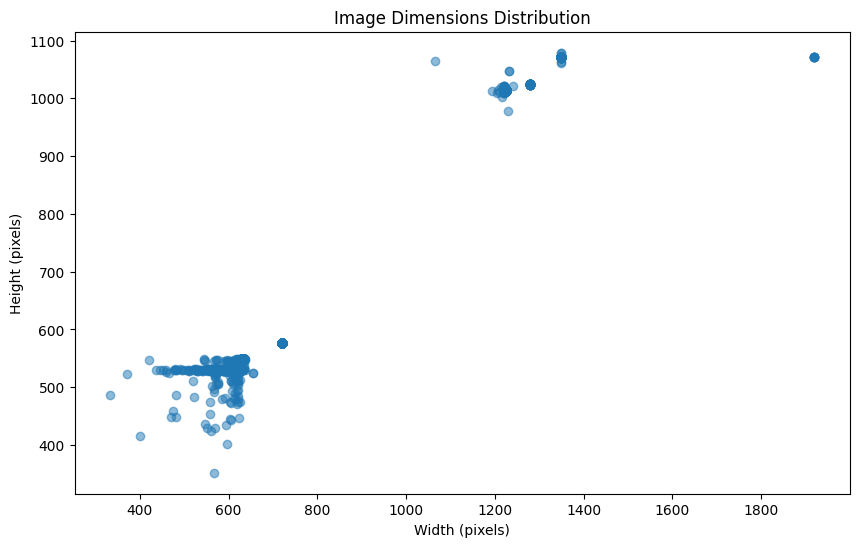

Epoch 1/10, Loss: 29.5635
Epoch 2/10, Loss: 0.0555
Epoch 3/10, Loss: 0.0183
Epoch 4/10, Loss: 0.0354
Epoch 5/10, Loss: 0.0014
Epoch 6/10, Loss: 0.0004
Epoch 7/10, Loss: 0.0009
Epoch 8/10, Loss: 0.0001
Epoch 9/10, Loss: 0.0001
Epoch 10/10, Loss: 0.0000


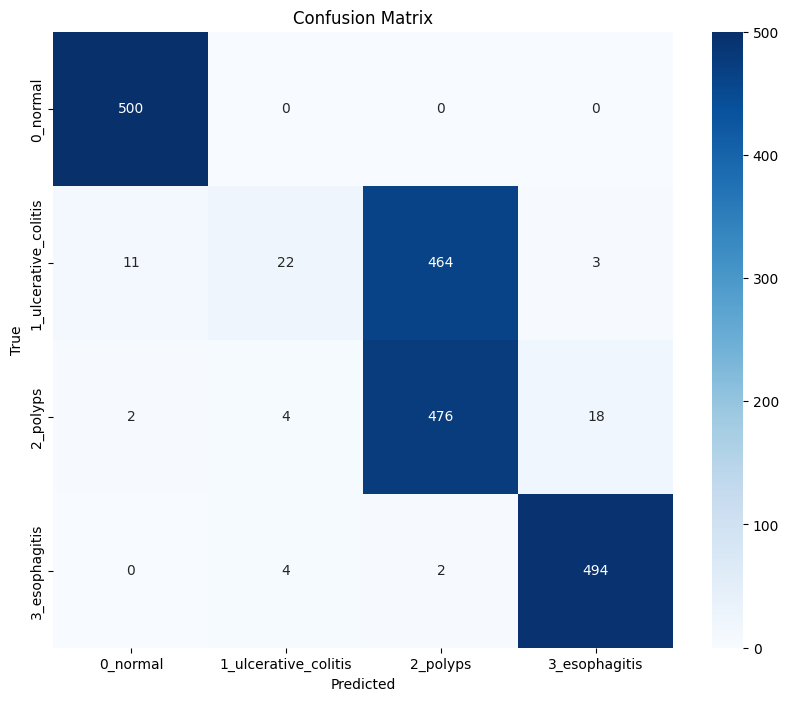

                      precision    recall  f1-score   support

            0_normal       0.97      1.00      0.99       500
1_ulcerative_colitis       0.73      0.04      0.08       500
            2_polyps       0.51      0.95      0.66       500
       3_esophagitis       0.96      0.99      0.97       500

            accuracy                           0.75      2000
           macro avg       0.79      0.75      0.68      2000
        weighted avg       0.79      0.75      0.68      2000



In [3]:
#Model Architecture
def create_data_loaders(data_root, batch_size=BATCH_SIZE):
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.ConvertImageDtype(torch.float),
    ])
    train_dataset = EndoscopicImageDataset(root_dir=data_root + '/train', transform=transform)
    val_dataset = EndoscopicImageDataset(root_dir=data_root + '/val', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

class EndoscopicCNN(nn.Module):
    def __init__(self, num_classes):
        super(EndoscopicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
#Training/Evaluation
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

#Confusion matrix
def plot_confusion_matrix(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
#Image Analysis (data explorationn)
def analyze_image_sizes(dataset):
    sizes = [Image.open(sample[0]).size for sample in dataset.samples]
    widths, heights = zip(*sizes)
    plt.figure(figsize=(10, 6))
    plt.scatter(widths, heights, alpha=0.5)
    plt.title('Image Dimensions Distribution')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.show()
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader = create_data_loaders(DATA_ROOT)
    model = EndoscopicCNN(num_classes=len(CLASS_NAMES)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # EDA (run)
    analyze_image_sizes(train_loader.dataset)

    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {train_loss:.4f}")

    # Evaluation
    val_preds, val_labels = evaluate_model(model, val_loader, device)
    plot_confusion_matrix(val_labels, val_preds)
    print(classification_report(val_labels, val_preds, target_names=CLASS_NAMES))

if __name__ == "__main__":
    main()

Results Analysis and Conclusion:

The CNN model demonstrated promising initial results, with a rapid decrease in loss values during training, indicating efficient feature capture from the dataset. Evaluation metrics revealed varied performance across classes, with high precision and recall for normal and esophagitis categories (F1-scores of 0.99 and 0.97, respectively). However, the model struggled significantly with ulcerative colitis classification, achieving only 0.73 precision and 0.04 recall, resulting in a low F1-score of 0.08. The polyps class showed mixed results with high recall (0.95) but lower precision (0.51), suggesting a tendency for false positives. Overall model accuracy was moderate at 75%, highlighting the need for further refinement.

In conclusion, while the model shows potential, particularly for normal and esophagitis classes, significant improvements are required for accurate classification of ulcerative colitis and polyps. Future work should focus on addressing class imbalances through techniques such as data augmentation, re-sampling methods, or exploring more advanced architectures. Implementing transfer learning from pre-trained models could enhance performance, especially for challenging classes. This analysis underscores the importance of continued model refinement to improve diagnostic accuracy, ultimately contributing to enhanced clinical decision-making in gastrointestinal health.


GitHub Repo: https://github.com/cherylblackmer/deep-learning-wireless-capsule-endoscopy

Dataset Link: https://www.kaggle.com/datasets/francismon/curated-colon-dataset-for-deep-learning/data

Additional Sources:

https://link.springer.com/article/10.1007/s11548-013-0926-3

https://www.sciencedirect.com/science/article/abs/pii/S1746809422002051

https://medium.com/@esrasoylu/creating-a-cnn-model-for-image-classification-with-tensorflow-49b84be8c12a
